In [52]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os
import tensorflow as tf
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_log_error
from math import sqrt
from datetime import datetime
from datetime import timedelta
# from tensorflow.keras import layers
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Masking
from keras.layers import BatchNormalization
from keras.layers import ZeroPadding2D
from keras.layers import Activation
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()



In [3]:
train_df = gpd.read_file("enriched_covid_19_week_2.csv")
train_df["Country_Region"] = [country_name.replace("'","") for country_name in train_df["Country_Region"]]
train_df["restrictions"] = train_df["restrictions"].astype("int")
train_df["quarantine"] = train_df["quarantine"].astype("int")
train_df["schools"] = train_df["schools"].astype("int")
train_df["total_pop"] = train_df["total_pop"].astype("float")
train_df["density"] = train_df["density"].astype("float")
train_df["hospibed"] = train_df["hospibed"].astype("float")
train_df["lung"] = train_df["lung"].astype("float")
train_df["total_pop"] = train_df["total_pop"]/max(train_df["total_pop"])
train_df["density"] = train_df["density"]/max(train_df["density"])
train_df["hospibed"] = train_df["hospibed"]/max(train_df["hospibed"])
train_df["lung"] = train_df["lung"]/max(train_df["lung"])
train_df.head()

,Id,Country_Region,Province_State,Date,ConfirmedCases,Fatalities,age_0-4,age_5-9,age_10-14,age_15-19,...,density,urbanpop,hospibed,lung,femalelung,malelung,restrictions,quarantine,schools,geometry
0,1,Afghanistan,,2020-01-22,0.0,0.0,0.1457166900587929,0.13913315751113053,0.13337619499377074,0.1189222268680805,...,0.002278,25.0,0.036232,0.329191,36.31,39.33,0,0,0,None
1,2,Afghanistan,,2020-01-23,0.0,0.0,0.1457166900587929,0.13913315751113053,0.13337619499377074,0.1189222268680805,...,0.002278,25.0,0.036232,0.329191,36.31,39.33,0,0,0,None
2,3,Afghanistan,,2020-01-24,0.0,0.0,0.1457166900587929,0.13913315751113053,0.13337619499377074,0.1189222268680805,...,0.002278,25.0,0.036232,0.329191,36.31,39.33,0,0,0,None
3,4,Afghanistan,,2020-01-25,0.0,0.0,0.1457166900587929,0.13913315751113053,0.13337619499377074,0.1189222268680805,...,0.002278,25.0,0.036232,0.329191,36.31,39.33,0,0,0,None
4,5,Afghanistan,,2020-01-26,0.0,0.0,0.1457166900587929,0.13913315751113053,0.13337619499377074,0.1189222268680805,...,0.002278,25.0,0.036232,0.329191,36.31,39.33,0,0,0,None


In [4]:
train_df.columns

Index(['Id', 'Country_Region', 'Province_State', 'Date', 'ConfirmedCases',
       'Fatalities', 'age_0-4', 'age_5-9', 'age_10-14', 'age_15-19',
       'age_20-24', 'age_25-29', 'age_30-34', 'age_35-39', 'age_40-44',
       'age_45-49', 'age_50-54', 'age_55-59', 'age_60-64', 'age_65-69',
       'age_70-74', 'age_75-79', 'age_80-84', 'age_85-89', 'age_90-94',
       'age_95-99', 'age_100+', 'total_pop', 'smokers_perc', 'density',
       'urbanpop', 'hospibed', 'lung', 'femalelung', 'malelung',
       'restrictions', 'quarantine', 'schools', 'geometry'],
      dtype='object')

In [5]:
trend_df = pd.DataFrame(columns={"infection_trend","fatality_trend","quarantine_trend","school_trend","total_population","expected_cases","expected_fatalities"})

In [6]:
train_df = train_df.query("Date>'2020-01-22'and Date<='2020-03-18'")
days_in_sequence = 14

trend_list = []

with tqdm(total=len(list(train_df.Country_Region.unique()))) as pbar:
    for country in train_df.Country_Region.unique():
        for province in train_df.query(f"Country_Region=='{country}'").Province_State.unique():
            province_df = train_df.query(f"Country_Region=='{country}' and Province_State=='{province}'")
            
            #I added a quick hack to double the number of sequences
            #Warning: This will later create a minor leakage from the 
            # training set into the validation set.
            for i in range(0,len(province_df),int(days_in_sequence/2)):
                if i+days_in_sequence<=len(province_df):
                    #prepare all the temporal inputs
                    infection_trend = [float(x) for x in province_df[i:i+days_in_sequence-1].ConfirmedCases.values]
                    fatality_trend = [float(x) for x in province_df[i:i+days_in_sequence-1].Fatalities.values]
                    restriction_trend = [float(x) for x in province_df[i:i+days_in_sequence-1].restrictions.values]
                    quarantine_trend = [float(x) for x in province_df[i:i+days_in_sequence-1].quarantine.values]
                    school_trend = [float(x) for x in province_df[i:i+days_in_sequence-1].schools.values]

                    #preparing all the demographic inputs
                    total_population = float(province_df.iloc[i].total_pop)
                    density = float(province_df.iloc[i].density)
                    hospibed = float(province_df.iloc[i].hospibed)
                    lung = float(province_df.iloc[i].lung)

                    expected_cases = float(province_df.iloc[i+days_in_sequence-1].ConfirmedCases)
                    expected_fatalities = float(province_df.iloc[i+days_in_sequence-1].Fatalities)

                    trend_list.append({"infection_trend":infection_trend,
                                     "fatality_trend":fatality_trend,
                                     "restriction_trend":restriction_trend,
                                     "quarantine_trend":quarantine_trend,
                                     "school_trend":school_trend,
                                     "demographic_inputs":[total_population,density,hospibed,lung],
                                     "expected_cases":expected_cases,
                                     "expected_fatalities":expected_fatalities})
        pbar.update(1)
trend_df = pd.DataFrame(trend_list)

100%|██████████| 294/294 [00:13<00:00, 21.88it/s]


In [7]:
trend_df["temporal_inputs"] = [np.asarray([trends["infection_trend"],trends["fatality_trend"],trends["restriction_trend"],trends["quarantine_trend"],trends["school_trend"]]) for idx,trends in trend_df.iterrows()]

trend_df = shuffle(trend_df)

In [8]:
i=0
y=0
temp_df = pd.DataFrame()
for idx,row in trend_df.iterrows():
    if sum(row.infection_trend)>0:
        temp_df = temp_df.append(row)
    else:
        if i<25:
            temp_df = temp_df.append(row)
            i+=1
trend_df = temp_df

In [9]:
trend_df.head()

,demographic_inputs,expected_cases,expected_fatalities,fatality_trend,infection_trend,quarantine_trend,restriction_trend,school_trend,temporal_inputs
30,"[0.022834520344690704, 0.003607092683297262, 0...",0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
894,"[0.001367307367216461, 0.003607092683297262, 0...",0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
678,"[0.006419985667519448, 0.003607092683297262, 0...",0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1534,"[0.000916014884084031, 0.003607092683297262, 0...",0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
96,"[0.017716570420520272, 0.003607092683297262, 0...",3.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."


In [24]:
# Splitting my dataset with 80% for training and 10% for validation
sequence_length = 13
training_percentage = 0.8
training_item_count = int(len(trend_df)*training_percentage)
validation_item_count = len(trend_df)-int(len(trend_df)*training_percentage)
training_df = trend_df[:training_item_count]
validation_df = trend_df[training_item_count:]

In [45]:
X_temporal_train = np.asarray(np.reshape(np.asarray([np.asarray(x) for x in training_df["temporal_inputs"].values]),(training_item_count,5,sequence_length))).astype(np.float32)
X_demographic_train = np.asarray([np.asarray(x) for x in training_df["demographic_inputs"]]).astype(np.float32)
Y_cases_train = np.asarray([np.asarray(x) for x in training_df["expected_cases"]]).astype(np.float32)
Y_fatalities_train = np.asarray([np.asarray(x) for x in training_df["expected_fatalities"]]).astype(np.float32)

In [46]:
X_temporal_test = np.asarray(np.reshape(np.asarray([np.asarray(x) for x in validation_df["temporal_inputs"]]),(validation_item_count,5,sequence_length))).astype(np.float32)
X_demographic_test = np.asarray([np.asarray(x) for x in validation_df["demographic_inputs"]]).astype(np.float32)
Y_cases_test = np.asarray([np.asarray(x) for x in validation_df["expected_cases"]]).astype(np.float32)
Y_fatalities_test = np.asarray([np.asarray(x) for x in validation_df["expected_fatalities"]]).astype(np.float32)

In [27]:
X_demographic_test.shape

(171, 4)

In [69]:
#temporal input branch
temporal_input_layer = Input(shape=(5,sequence_length))
main_rnn_layer = layers.LSTM(128, return_sequences=True, recurrent_dropout=0.2)(temporal_input_layer)

#demographic input branch
demographic_input_layer = Input(shape=(4))
demographic_dense = layers.Dense(16)(demographic_input_layer)
demographic_dropout = layers.Dropout(0.2)(demographic_dense)

#cases output branch
blstm1_c = layers.Bidirectional(layers.LSTM(50,return_sequences=True,
                                         kernel_initializer='he_normal',
                                         dropout=0.02,recurrent_dropout = 0.02))(main_rnn_layer)
dense1_c = layers.Dense(100, activation = 'relu')(blstm1_c)
blstm2_c = layers.Bidirectional(layers.LSTM(50,return_sequences=True,
                                         kernel_initializer='he_normal',
                                         dropout=0.02,recurrent_dropout = 0.02))(dense1_c)
# blstm3_c = layers.Bidirectional(layers.LSTM(50,return_sequences=True))(dense2_c)
blstm3_c = layers.Bidirectional(layers.LSTM(50,return_sequences=True,
                                            kernel_initializer='he_normal',
                                            dropout=0.02,recurrent_dropout = 0.02))(blstm2_c)
blstm4_c = layers.Bidirectional(layers.LSTM(30,return_sequences=True,
                                            kernel_initializer='he_normal',
                                            dropout=0.02,recurrent_dropout = 0.02))(blstm3_c)
dense2_c = layers.Dense(50, activation = 'relu')(blstm4_c)
lstm1_c = layers.LSTM(50, kernel_initializer='he_normal',
                      dropout=0.02,recurrent_dropout = 0.02)(dense2_c)
merge_c = layers.Concatenate(axis=-1)([lstm1_c,demographic_dropout])
dense3_c = layers.Dense(100)(merge_c)
dropout_c = layers.Dropout(0.3)(dense3_c)
cases = layers.Dense(1, activation = 'relu',name="cases")(dropout_c)

#fatality output branch
blstm1_f = layers.Bidirectional(layers.LSTM(50,return_sequences=True,
                                         kernel_initializer='he_normal',
                                         dropout=0.02,recurrent_dropout = 0.02))(main_rnn_layer)
dense1_f = layers.Dense(100, activation = 'relu')(blstm1_f)
blstm2_f = layers.Bidirectional(layers.LSTM(50,return_sequences=True,
                                         kernel_initializer='he_normal',
                                         dropout=0.02,recurrent_dropout = 0.02))(dense1_f)
blstm3_f = layers.Bidirectional(layers.LSTM(50,return_sequences=True,
                                            kernel_initializer='he_normal',
                                            dropout=0.02,recurrent_dropout = 0.02))(blstm2_f)
blstm4_f = layers.Bidirectional(layers.LSTM(30,return_sequences=True,
                                            kernel_initializer='he_normal',
                                            dropout=0.02,recurrent_dropout = 0.02))(blstm3_f)
dense2_f = layers.Dense(50, activation = 'relu')(blstm4_f)
lstm1_f = layers.LSTM(50, kernel_initializer='he_normal',
                      dropout=0.02,recurrent_dropout = 0.02)(dense2_f)
merge_f = layers.Concatenate(axis=-1)([lstm1_f,demographic_dropout])
dense3_f = layers.Dense(100)(merge_f)
dropout_f = layers.Dropout(0.3)(dense3_f)
cases = layers.Dense(1, activation = 'relu',name="cases")(dropout_f)

fatalities = layers.Dense(1, activation = 'relu', name="fatalities")(dropout_f)


model = Model([temporal_input_layer,demographic_input_layer], [cases,fatalities])

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 5, 13)]      0                                            
__________________________________________________________________________________________________
lstm_9 (LSTM)                   (None, 5, 128)       72704       input_7[0][0]                    
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, 5, 100)       71600       lstm_9[0][0]                     
______________________________________________________

In [70]:
################################## set GPU ##########################################
import os
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF
os.environ["CUDA_VISIBLE_DEVICES"]="1"
config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.6 
session = tf.Session(config=config)
KTF.set_session(session )

Using TensorFlow backend.


In [72]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.6),
             EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
model.compile(loss=[tf.keras.losses.MeanSquaredLogarithmicError(),tf.keras.losses.MeanSquaredLogarithmicError()], optimizer="adam")
history = model.fit([X_temporal_train,X_demographic_train], [Y_cases_train, Y_fatalities_train], 
          epochs = 250, 
          batch_size = 16, 
          validation_data=([X_temporal_test,X_demographic_test],  [Y_cases_test, Y_fatalities_test]), 
          callbacks=callbacks)

Train on 680 samples, validate on 171 samples
Epoch 1/250
680/680 [==============================] - 24s 36ms/sample - loss: 9.1378 - cases_loss: 7.6150 - fatalities_loss: 1.4709 - val_loss: 4.7189 - val_cases_loss: 3.6567 - val_fatalities_loss: 1.0618
Epoch 2/250
680/680 [==============================] - 8s 12ms/sample - loss: 4.3734 - cases_loss: 3.2304 - fatalities_loss: 1.1342 - val_loss: 3.3659 - val_cases_loss: 2.6259 - val_fatalities_loss: 0.9408
Epoch 3/250
680/680 [==============================] - 7s 10ms/sample - loss: 3.3281 - cases_loss: 2.4614 - fatalities_loss: 0.8313 - val_loss: 2.7181 - val_cases_loss: 2.1008 - val_fatalities_loss: 0.5527
Epoch 4/250
680/680 [==============================] - 7s 10ms/sample - loss: 2.7330 - cases_loss: 2.0729 - fatalities_loss: 0.6747 - val_loss: 2.5133 - val_cases_loss: 1.7044 - val_fatalities_loss: 0.7623
Epoch 5/250
680/680 [==============================] - 8s 12ms/sample - loss: 2.5175 - cases_loss: 1.7851 - fatalities_loss: 0.70

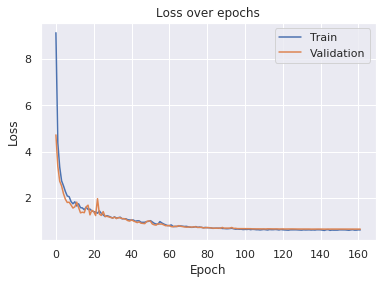

In [76]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()


In [44]:
predictions = model.predict([X_temporal_test,X_demographic_test])
Y_cases_prediction = predictions[0]
Y_fatalities_prediction = predictions[1]

Test RMSE: 1127.061


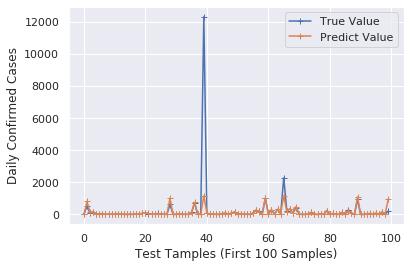

In [93]:
plt.plot([x for x in range(len(Y_cases_test[0:100])) ],Y_cases_test[0:100],[x for x in range(len(Y_cases_test[0:100])) ],Y_cases_prediction[0:100],marker='+', linestyle='-')
plt.xlabel('Test Tamples (First 100 Samples)')
plt.ylabel('Daily Confirmed Cases')
plt.legend(['True Value', 'Predict Value'])
rmse = sqrt(mean_squared_error(Y_cases_test, Y_cases_prediction))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.845


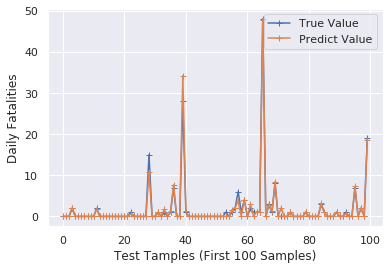

In [94]:
plt.plot([x for x in range(len(Y_fatalities_test[0:100])) ],Y_fatalities_test[0:100],[x for x in range(len(Y_fatalities_test[0:100])) ],Y_fatalities_prediction[0:100],marker='+', linestyle='-')
plt.xlabel('Test Tamples (First 100 Samples)')
plt.ylabel('Daily Fatalities')
plt.legend(['True Value', 'Predict Value'])
rmse = sqrt(mean_squared_error(Y_fatalities_test[0:100], Y_fatalities_prediction[0:100]))
print('Test RMSE: %.3f' % rmse)